In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import os
from io import open
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import time
from scipy.stats import gaussian_kde
import scipy.stats as stats

In [7]:
from dataset import Step2_DataSet
from time_series_models import GRUSeq2SeqWithAttention, TimeSeriesModel, SequenceDataset
# from sequence_dataset import SequenceDataset, train_test_split

In [8]:
import kgml_lib

In [9]:
# define functions from kgml_lib
Z_norm = kgml_lib.Z_norm 
Z_norm_reverse = kgml_lib.Z_norm_reverse
get_gpu_memory = kgml_lib.get_gpu_memory
# my_loss = kgml_lib.my_loss
# compute_r2=kgml_lib.R2Loss()

# myloss_mb_flux_mask = kgml_lib.myloss_mb_flux_mask
# check_Rh2SOC_response = kgml_lib.check_Rh2SOC_response

def stop_program():
    raise SystemExit("Program terminated due to using CPU.")


In [10]:
import torch
from torch.utils.data import DataLoader

In [11]:
root_dir = 'E:/PyKGML/deposit_code_v2/'
data_path = root_dir +  'processed_data/'
output_path = root_dir + 'test_results/'

input_data = 'recotest_data_scaled_v4_100sample.sav'
sample_index_file = "traindataset_split_year_v1.sav"

pretrained_model = "recotest_v11_exp4.sav_step1"
output_model = "recotest_v11_exp4_sample.sav_step2"
synthetic_data = "sys_data2.sav"

dataset = Step2_DataSet(data_path, input_data, output_path, sample_index_file)
dataset.load_step2_data()

dataset.prepare_step2_data()

torch.Size([6570, 100, 19]) torch.Size([6570, 100, 3]) torch.Size([18, 100, 1])
['RADN', 'TMAX_AIR', 'TDIF_AIR', 'HMAX_AIR', 'HDIF_AIR', 'WIND', 'PRECN', 'Crop_Type', 'GPP', 'Year', 'TBKDS', 'TSAND', 'TSILT', 'TFC', 'TWP', 'TKSat', 'TSOC', 'TPH', 'TCEC']


In [12]:
num_input_features = 19
num_output_features = 3

input_dim = num_input_features
hidden_dim = 128
num_layers = 3
output_dim = num_output_features
dropout=0.2

In [13]:
# Choose one of the models below:
#model = LSTMSeq2Seq(input_dim, hidden_dim, num_layers, output_dim)
# model = GRUSeq2Seq(input_dim, hidden_dim, num_layers, output_dim)

# model = EnhancedGRUModel(input_dim, hidden_dim, num_layers, output_dim)

# model = GRUSeq2SeqWithAttention(input_dim, hidden_dim, num_layers, output_dim, dropout)

model = GRUSeq2SeqWithAttention(input_dim, hidden_dim, num_layers, output_dim)

In [14]:
X = dataset.X  #[365*18, 100, 19]
X = torch.transpose(X,1, 0) #[100, 365*18, 19]

Y1 = dataset.Y1 #[365*18, 100, 3]
Y1 = torch.transpose(Y1,1, 0) #[100, 365*18, 3]

Y2 = dataset.Y2 #[18, 100, 1]
Y2 = torch.transpose(Y2,1, 0)

total_years = 18
# days_per_year = 365
# total_days = total_years * days_per_year
# num_sites = X.shape[0] #100

batch_size=64
# train_loader, test_loader = model.train_test_split(X, Y1, batch_size)
model.train_test_split(X, Y1, total_years, batch_size)

In [15]:
learning_rate = 0.001
step_size = 20
max_epoch = 60
loss_function = nn.L1Loss()

# model.train_model(train_loader, test_loader, LR= learning_rate, step_size=20, gamma=0.8, maxepoch=60)
model.train_model(loss_fun=loss_function, LR= learning_rate, step_size= step_size, gamma=0.8, maxepoch=max_epoch)

Epoch 1/60 | LR: 0.001000, Train Loss: 0.4526, Test Loss: 0.2711
Epoch 2/60 | LR: 0.001000, Train Loss: 0.2336, Test Loss: 0.1930
Epoch 3/60 | LR: 0.001000, Train Loss: 0.1910, Test Loss: 0.1686
Epoch 4/60 | LR: 0.001000, Train Loss: 0.1726, Test Loss: 0.1638
Epoch 5/60 | LR: 0.001000, Train Loss: 0.1637, Test Loss: 0.1532
Epoch 6/60 | LR: 0.001000, Train Loss: 0.1557, Test Loss: 0.1479
Epoch 7/60 | LR: 0.001000, Train Loss: 0.1489, Test Loss: 0.1396
Epoch 8/60 | LR: 0.001000, Train Loss: 0.1433, Test Loss: 0.1412
Epoch 9/60 | LR: 0.001000, Train Loss: 0.1407, Test Loss: 0.1346
Epoch 10/60 | LR: 0.001000, Train Loss: 0.1382, Test Loss: 0.1265
Epoch 11/60 | LR: 0.001000, Train Loss: 0.1368, Test Loss: 0.1258
Epoch 12/60 | LR: 0.001000, Train Loss: 0.1333, Test Loss: 0.1269
Epoch 13/60 | LR: 0.001000, Train Loss: 0.1306, Test Loss: 0.1263
Epoch 14/60 | LR: 0.001000, Train Loss: 0.1287, Test Loss: 0.1198
Epoch 15/60 | LR: 0.001000, Train Loss: 0.1267, Test Loss: 0.1155
Epoch 16/60 | LR: 0

In [16]:
# model.test(test_loader)
model.test()

Test Loss: 0.1018


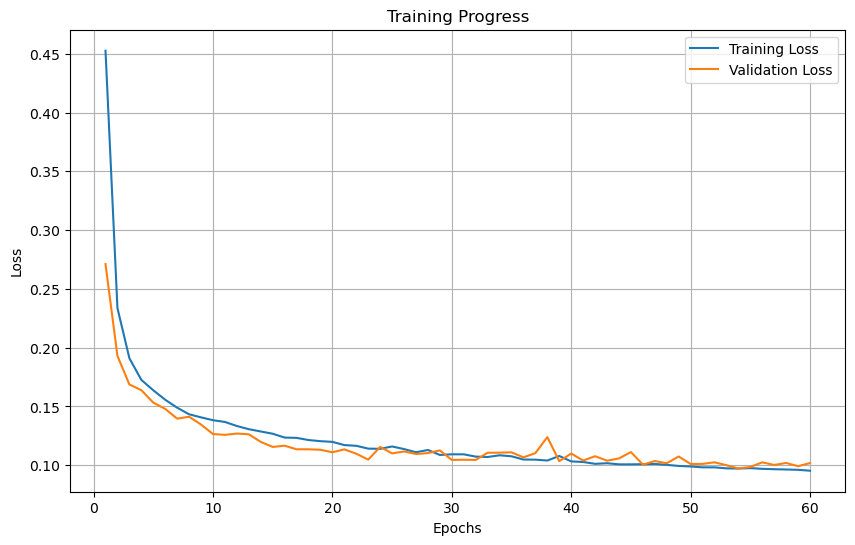

In [17]:
model.plot_training_curves()

In [18]:
y_scaler = dataset.Y1_scaler
output_feature_name = ['Ra','Rh','NEE']
model.get_R2_score(y_scaler, output_feature_name)

Feature Ra R2 Score is: 0.9717970807672692
Feature Rh R2 Score is: 0.9339261801106485
Feature NEE R2 Score is: 0.9759915514873039


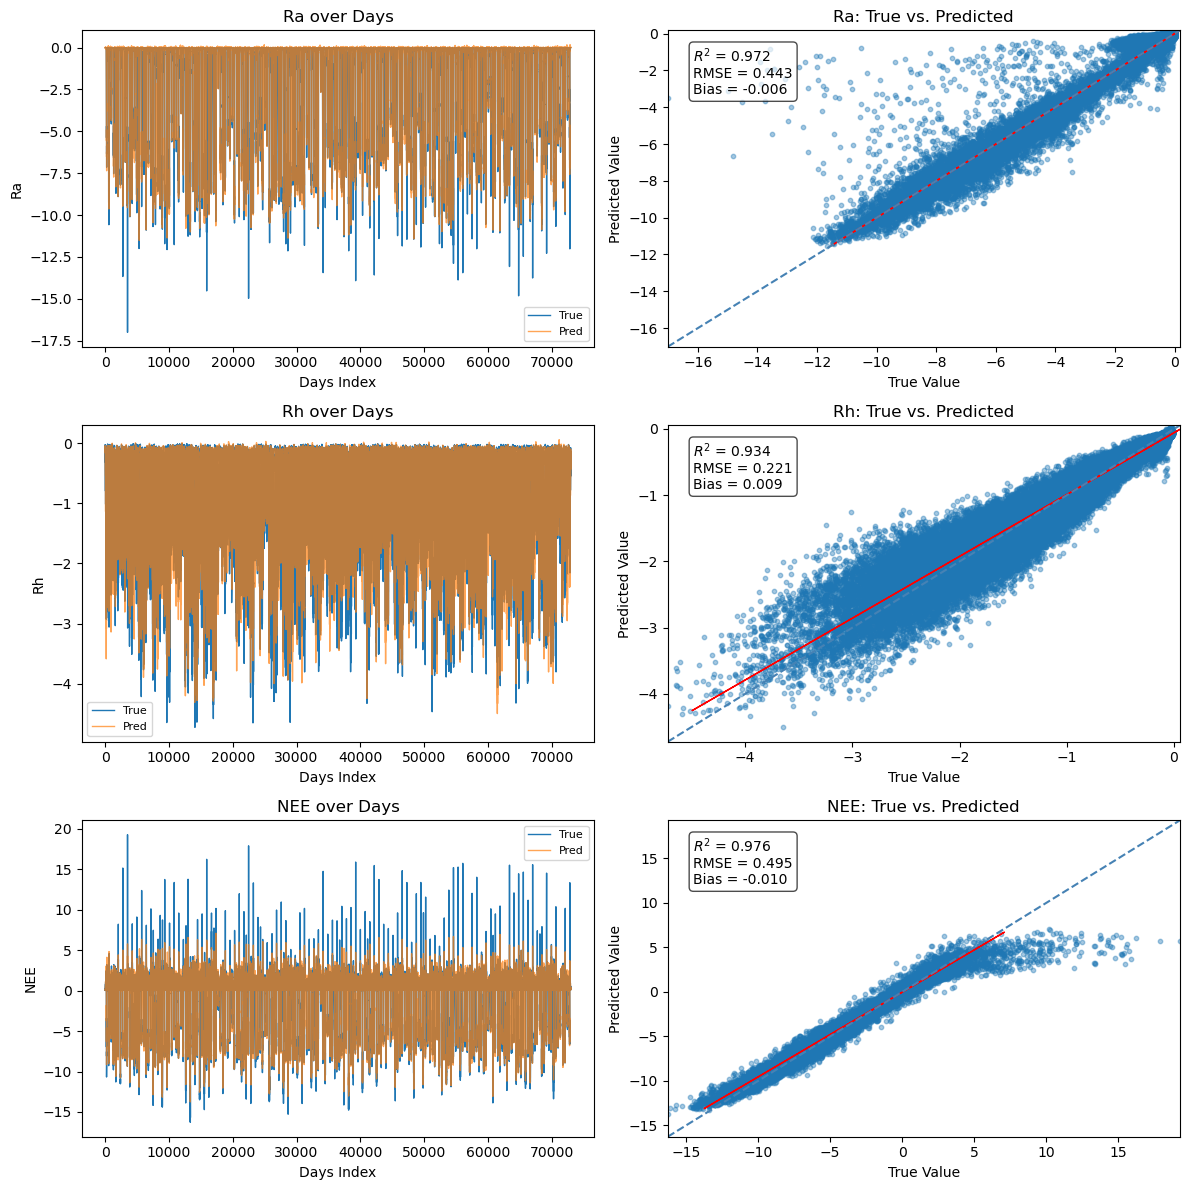

In [19]:
model.Vis_prediction_result(y_scaler, output_feature_name)